<a href="https://colab.research.google.com/github/Chirag314/Household-power-consumption/blob/main/household_power_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####Reference https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

In [1]:
#Import packages
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import time
import os

pd.set_option('display.float_format',lambda x: '%.4f' %x)
import seaborn as sns 
sns.set_context('paper',font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller

from keras.layers import *
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline





In [2]:
# read dataset
df=pd.read_csv('household_power_consumption.txt',delimiter=';')
#df=df.apply(lambda x:x.replace(';',''))
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [3]:
# Convert features for better analysis
df['date_time']=pd.to_datetime(df['Date']+' '+df['Time'])
df['Global_active_power']=pd.to_numeric(df['Global_active_power'],errors='coerce')
df=df.dropna(subset=['Global_active_power'])

df['date_time']=pd.to_datetime(df['date_time'])
df=df.loc[:,['date_time','Global_active_power']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)


In [4]:
df['year']=df['date_time'].apply(lambda x:x.year)
df['quarter']=df['date_time'].apply(lambda  x:x.quarter)
df['month']=df['date_time'].apply(lambda x:x.month)
df['day']=df['date_time'].apply(lambda x:x.day)
df=df.loc[:,['date_time','Global_active_power','year','quarter','month','day']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)
df['weekday']=df.apply(lambda row : row['date_time'].weekday(),axis=1)
df["weekday"]=(df['weekday']<5).astype(int)


print('Number of rows and columns after removing missing values:',df.shape)
print('The time series starts from:',df['date_time'].min())
print('The time series ends on:',df['date_time'].max())

Number of rows and columns after removing missing values: (2049280, 7)
The time series starts from: 2006-12-16 17:24:00
The time series ends on: 2010-12-11 23:59:00


In [5]:
# Check if data follows normal distribution or not
stat,p = stats.normaltest(df.Global_active_power)
print('Statistics=%.3f, p=%.3f' %(stat,p))
alpha=0.05
if p>alpha :
  print('Data looks Gaussian(fail to reject H0)')
else:
  print('Data does not look Gaussian (reject H0)')

Statistics=724881.795, p=0.000
Data does not look Gaussian (reject H0)


In [6]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 7 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date_time            datetime64[ns]
 1   Global_active_power  float64       
 2   year                 int64         
 3   quarter              int64         
 4   month                int64         
 5   day                  int64         
 6   weekday              int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 109.4 MB


,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0
5,2006-12-16 17:29:00,3.5200,2006,4,12,16,0
6,2006-12-16 17:30:00,3.7020,2006,4,12,16,0
7,2006-12-16 17:31:00,3.7000,2006,4,12,16,0
8,2006-12-16 17:32:00,3.6680,2006,4,12,16,0
9,2006-12-16 17:33:00,3.6620,2006,4,12,16,0


Kurtosis of normal distribution: 4.218671866132123
Skewness of normal distribution: 1.7862320846320832


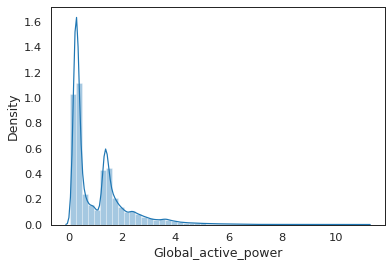

In [7]:
# check Kurtosis and skewness
sns.distplot(df.Global_active_power)
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print('Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

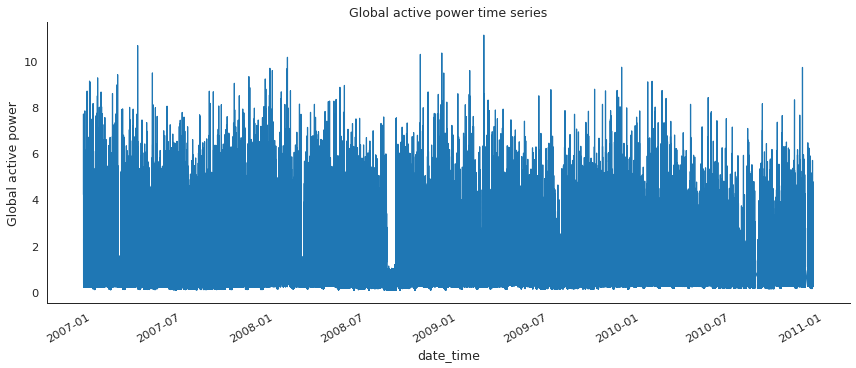

In [8]:
# Draw time series plot
df1=df.loc[:,['date_time' ,'Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global active power time series')
sns.despine(top=True)
plt.show()

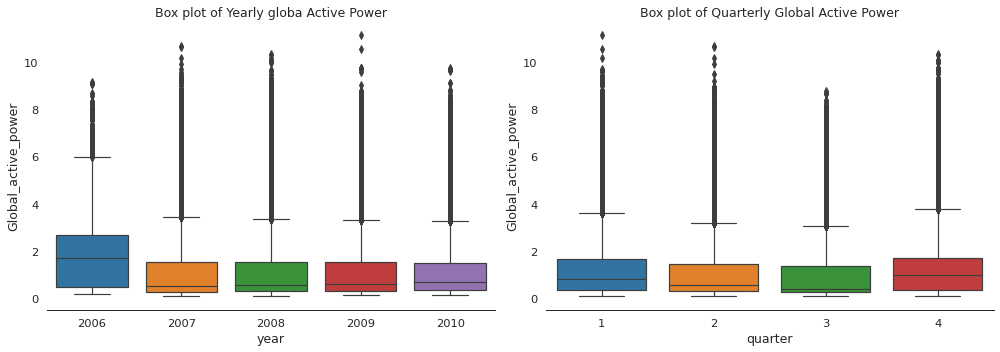

In [9]:
# Box plot of yearly vs quartly global active power
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x='year', y='Global_active_power',data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly globa Active Power')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x='quarter',y='Global_active_power',data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout()


,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0000,1.0916,1.0573,0.0760,0.3080,0.6020,1.5280,11.1220


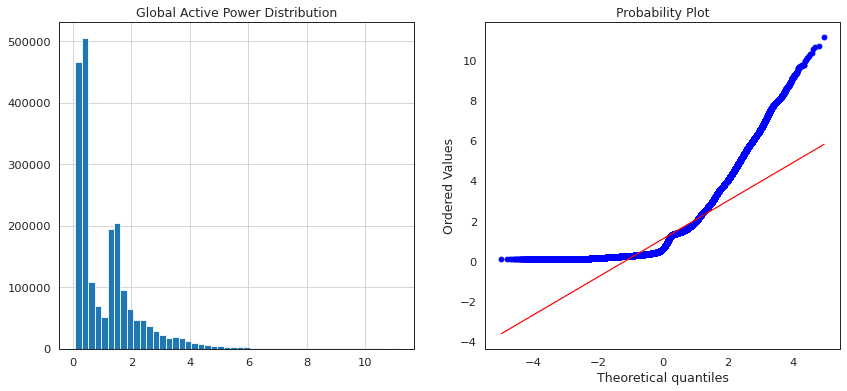

In [11]:
# Check the distribution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'],plot=plt)
df1.describe().T

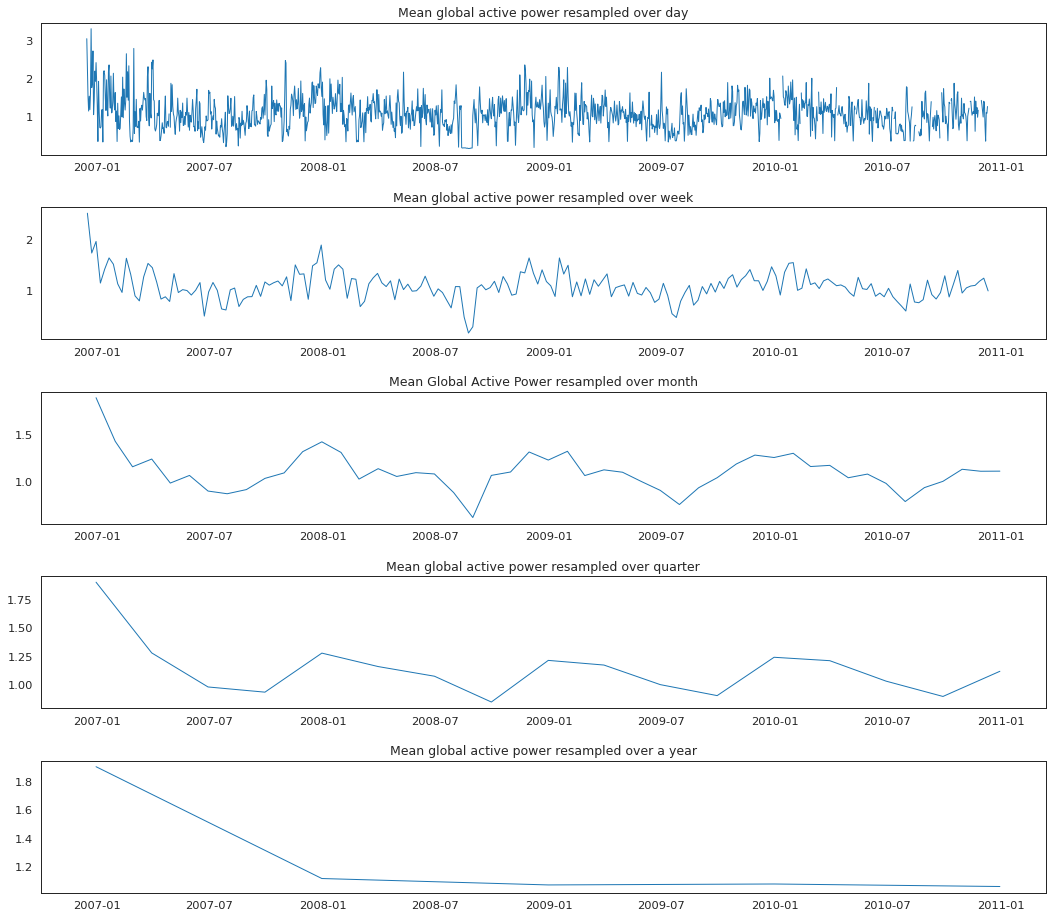

In [21]:
# Plot average global active power resampled over day,week,month quarter and year
fig=plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=0.4)
ax1=fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean global active power resampled over day')
ax1.tick_params(axis='both',which='major')

ax2=fig.add_subplot(5,1,2,sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean global active power resampled over week')
ax2.tick_params(axis='both',width='major')

ax3=fig.add_subplot(5,1,3,sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title("Mean Global Active Power resampled over month")
ax3.tick_params(axis='both',which='major')

ax4=fig.add_subplot(5,1,4,sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean global active power resampled over quarter')
ax4.tick_params(axis='both',which='major')

ax5=fig.add_subplot(5,1,5,sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean global active power resampled over a year')
ax5.tick_params(axis='both',which='major')

In [ ]:
#Split dataset into test and validation

test_cutoff_date=df['date_time'].max()-timedelta(days-7)
val_cutoff_date=test_cutoff_date-timedelta(days-14)



NameError: ignored